In [ ]:
 !python -m spacy download en_core_web_md

2024-01-30 07:03:16.709300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 07:03:16.709356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 07:03:16.710678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 07:03:16.717684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-30 07:03:17.782527: W tensorflow/compiler/tf2

# Load Dataset

Download Dataset: https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format

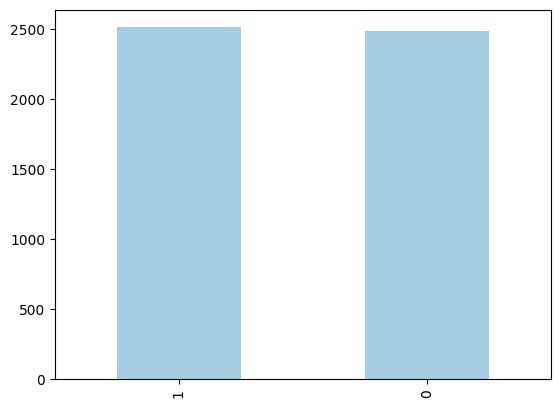

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Create the movie comment DataFrame and display the statistics
mcommentDF=pd.read_csv('/content/drive/MyDrive/StudyWork/Dataset/IMDB_Sentiment_5k.csv')
mcommentDF = mcommentDF[['text','label']].dropna()
axplot=mcommentDF.label.value_counts().plot(kind='bar', colormap='Paired')
plt.show()

# Tokenize dataset

In [ ]:
# Import spaCy
import spacy
# Load the spaCy NLP model
nlp = spacy.load("en_core_web_md")

# Save Features

In [ ]:
# Create movie comment sample and categories objects
movie_comment_exp = []
categories = []
# Perform Tokenization
for idx, rw in mcommentDF.iterrows():
  comments = rw["text"]
  rating = rw["label"]
  categories.append(rating)
  mtoks = [token.text for token in nlp(comments)]
  movie_comment_exp.append(mtoks)

In [ ]:
features = dict(
    features = movie_comment_exp,
    categories=categories,
)

In [ ]:
import pickle

# Lưu danh sách vào tệp
with open('feature_5k.pkl', 'wb') as file:
    pickle.dump(features, file)

In [ ]:
!cp /content/feature_5k.pkl -d /content/drive/MyDrive/StudyWork/Dataset

# Load Features

In [ ]:
import pickle

# Đọc danh sách từ tệp
with open('/content/drive/MyDrive/StudyWork/Dataset/feature_5k.pkl', 'rb') as file:
    loaded_list = pickle.load(file)

In [ ]:
# loaded_list

movie_comment_exp = loaded_list['features']
categories = loaded_list['categories']

In [ ]:
len(movie_comment_exp)

5000

# Preprocess Data

In [ ]:
# Import Tokenizer, pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:
# Create ktoken and perform tokenization
ktoken = Tokenizer(lower=True)
ktoken.fit_on_texts(movie_comment_exp)
# Create utterance sequences object
seq_utterance = ktoken.texts_to_sequences(movie_comment_exp)

In [ ]:
# Set the max length to 50
MLEN = 50
# Create pad utterance sequence object
ps_utterance = pad_sequences(seq_utterance, MLEN, padding="post")

In [ ]:
# Convert the ps_utterance into numpy arrays
ps_utterance = np.array(ps_utterance)
# Create the category list (catlist)
catlist = np.array(categories)

In [ ]:
catlist = catlist.reshape(catlist.shape[0] , 1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assume ps_utterance and catlist are processed data
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(ps_utterance, catlist, test_size=0.2, random_state=42)

# LSTM Model

In [ ]:
# Import the LSTM model and the optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Flatten
from tensorflow.keras import optimizers

In [ ]:
utterance_input = Input(shape=(None,))

In [ ]:
# Create the Embedding_Layer
embedding = Embedding(input_dim = len(ktoken.word_index)+1, output_dim = 100)(utterance_input)

In [ ]:
# Create the LSTM_Layer
LSTM_layer = LSTM(units=256)(embedding)

In [ ]:
# Create the Output Layer
outlayer = Dense(1, activation='sigmoid')(LSTM_layer)

In [ ]:
# Create the IMDB User Review LSTM Model (imdb_mdl)
imdb_mdl = Model(inputs=[utterance_input],outputs=[outlayer])

In [ ]:
imdb_mdl.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         4651300   
                                                                 
 lstm_5 (LSTM)               (None, 256)               365568    
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 5017125 (19.14 MB)
Trainable params: 5017125 (19.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
imdb_mdl.compile(optimizer="adam", loss="binary_crossentropy",
metrics=["accuracy"])

In [ ]:
# Model fitting by using 5 epochs
history = imdb_mdl.fit(x=X_train,
y=y_train,
batch_size=64,
epochs=30,
validation_split=0.2)

Epoch 1/30
50/50 [==============================] - 7s 108ms/step - loss: 0.6864 - accuracy: 0.5644 - val_loss: 0.6678 - val_accuracy: 0.6250
Epoch 2/30
50/50 [==============================] - 5s 103ms/step - loss: 0.5057 - accuracy: 0.7713 - val_loss: 0.5168 - val_accuracy: 0.7450
Epoch 3/30
50/50 [==============================] - 2s 45ms/step - loss: 0.1872 - accuracy: 0.9347 - val_loss: 0.5479 - val_accuracy: 0.7588
Epoch 4/30
50/50 [==============================] - 1s 28ms/step - loss: 0.0515 - accuracy: 0.9884 - val_loss: 0.8221 - val_accuracy: 0.7450
Epoch 5/30
50/50 [==============================] - 1s 26ms/step - loss: 0.0131 - accuracy: 0.9966 - val_loss: 1.2569 - val_accuracy: 0.7200
Epoch 6/30
50/50 [==============================] - 1s 21ms/step - loss: 0.0038 - accuracy: 0.9994 - val_loss: 1.1540 - val_accuracy: 0.7325
Epoch 7/30
50/50 [==============================] - 1s 12ms/step - loss: 6.8985e-04 - accuracy: 1.0000 - val_loss: 1.3221 - val_accuracy: 0.7362
Epoch 8

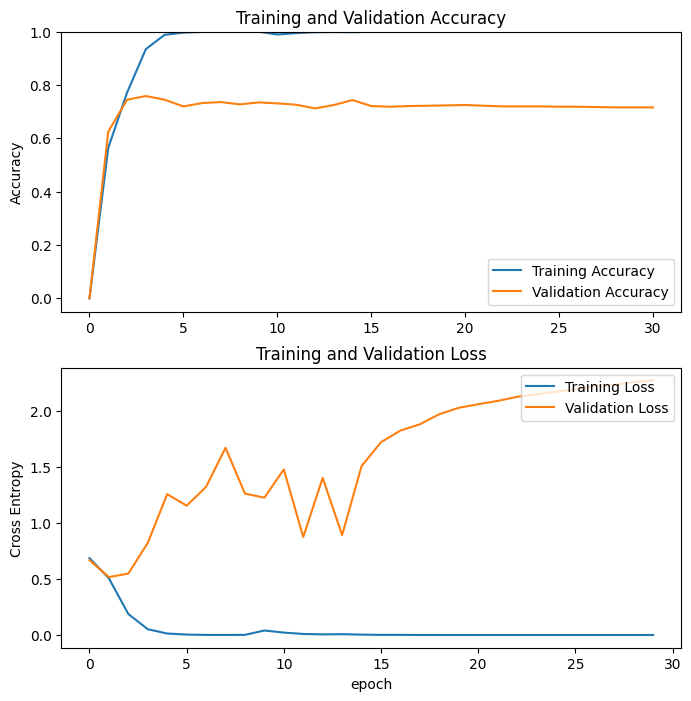

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluate LSTM

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = imdb_mdl.predict(X_test)
y_pred = np.round(y_pred)

cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

32/32 [==============================] - 1s 3ms/step
Confusion Matrix:
[[365 146]
 [143 346]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.71      0.72       511
           1       0.70      0.71      0.71       489

    accuracy                           0.71      1000
   macro avg       0.71      0.71      0.71      1000
weighted avg       0.71      0.71      0.71      1000



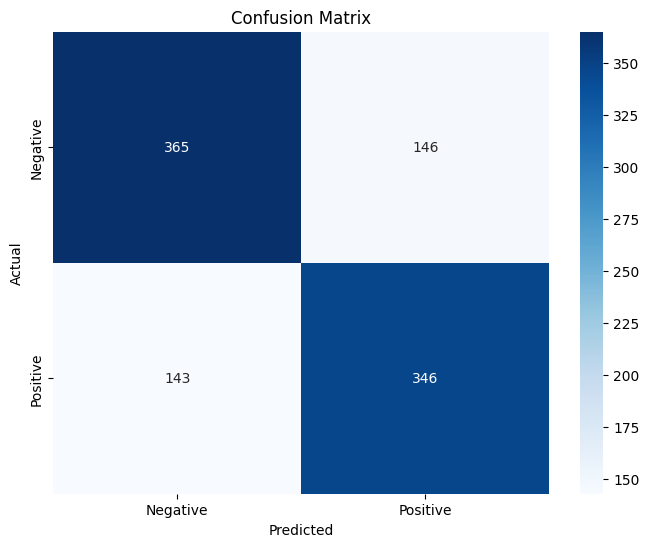

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
imdb_mdl.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         4651300   
                                                                 
 lstm_5 (LSTM)               (None, 256)               365568    
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 5017125 (19.14 MB)
Trainable params: 5017125 (19.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
len(X_test)

1000

# Dense

In [ ]:
utterance_input = Input(shape=(None,))
embedding = Embedding(input_dim=len(ktoken.word_index) + 1, output_dim=100)(utterance_input)
dense_layer1 = Dense(128, activation='relu')(embedding)
dense_layer2 = Dense(64, activation='relu')(dense_layer1)
outlayer = Dense(1, activation='sigmoid')(dense_layer2)

dense_model = Model(inputs=[utterance_input], outputs=[outlayer])

In [ ]:
dense_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         4651300   
                                                                 
 dense (Dense)               (None, None, 128)         12928     
                                                                 
 dense_1 (Dense)             (None, None, 64)          8256      
                                                                 
 dense_2 (Dense)             (None, None, 1)           65        
                                                                 
Total params: 4672549 (17.82 MB)
Trainable params: 4672549 (17.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
dense_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Model fitting by using 5 epochs
dense_model.fit(x=ps_utterance,
y=catlist,
batch_size=64,
epochs=5,
validation_split=0.3)

Epoch 1/5
55/55 [==============================] - 8s 114ms/step - loss: 0.6918 - accuracy: 0.5207 - val_loss: 0.6891 - val_accuracy: 0.5346
Epoch 2/5
55/55 [==============================] - 4s 80ms/step - loss: 0.6785 - accuracy: 0.5725 - val_loss: 0.6843 - val_accuracy: 0.5443
Epoch 3/5
55/55 [==============================] - 4s 79ms/step - loss: 0.6582 - accuracy: 0.5866 - val_loss: 0.6941 - val_accuracy: 0.5398
Epoch 4/5
55/55 [==============================] - 5s 97ms/step - loss: 0.6440 - accuracy: 0.5875 - val_loss: 0.7026 - val_accuracy: 0.5402
Epoch 5/5
55/55 [==============================] - 4s 79ms/step - loss: 0.6352 - accuracy: 0.5897 - val_loss: 0.7105 - val_accuracy: 0.5452


# CNN + LSTM + DENSE

In [ ]:
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, BatchNormalization, Dropout, Activation
from keras.models import Model

# Define input shape
utterance_input = Input(shape=(None,))

# Embedding layer
embedding = Embedding(input_dim=len(ktoken.word_index) + 1, output_dim=100)(utterance_input)

# Convolutional layers
conv1d_1 = Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation='relu')(embedding)
maxpool_1 = MaxPooling1D(pool_size=2, strides=1, padding="valid")(conv1d_1)
conv1d_2 = Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu')(maxpool_1)
maxpool_2 = MaxPooling1D(pool_size=2, strides=1, padding="valid")(conv1d_2)

# LSTM layer
lstm_1 = LSTM(128, return_sequences=True)(maxpool_2)
lstm_2 = LSTM(128)(lstm_1)

# Dense layers
dense_layer1 = Dense(64)(lstm_2)
bn_dense_1 = BatchNormalization()(dense_layer1)
dropout_1 = Dropout(0.2)(bn_dense_1)
relu_1 = Activation('relu')(dropout_1)

dense_layer2 = Dense(16)(relu_1)
bn_dense_2 = BatchNormalization()(dense_layer2)
dropout_2 = Dropout(0.1)(bn_dense_2)
relu_2 = Activation('relu')(dropout_2)

# Output layer
outlayer = Dense(1, activation='sigmoid')(relu_2)

# Define the model
combined_model = Model(inputs=utterance_input, outputs=outlayer)

In [ ]:
combined_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Model fitting by using 5 epochs
history = combined_model.fit(x=X_train,
y=y_train,
batch_size=64,
epochs=30,
validation_split=0.2)

Epoch 1/30
50/50 [==============================] - 14s 156ms/step - loss: 0.7176 - accuracy: 0.5322 - val_loss: 0.6939 - val_accuracy: 0.4762
Epoch 2/30
50/50 [==============================] - 4s 77ms/step - loss: 0.4620 - accuracy: 0.7937 - val_loss: 0.6823 - val_accuracy: 0.5950
Epoch 3/30
50/50 [==============================] - 2s 43ms/step - loss: 0.1720 - accuracy: 0.9747 - val_loss: 0.9067 - val_accuracy: 0.4762
Epoch 4/30
50/50 [==============================] - 2s 36ms/step - loss: 0.0737 - accuracy: 0.9994 - val_loss: 0.7268 - val_accuracy: 0.5113
Epoch 5/30
50/50 [==============================] - 2s 32ms/step - loss: 0.0412 - accuracy: 1.0000 - val_loss: 0.5688 - val_accuracy: 0.7063
Epoch 6/30
50/50 [==============================] - 2s 37ms/step - loss: 0.0275 - accuracy: 1.0000 - val_loss: 0.7040 - val_accuracy: 0.6363
Epoch 7/30
50/50 [==============================] - 2s 32ms/step - loss: 0.0210 - accuracy: 1.0000 - val_loss: 0.6098 - val_accuracy: 0.6950
Epoch 8/30


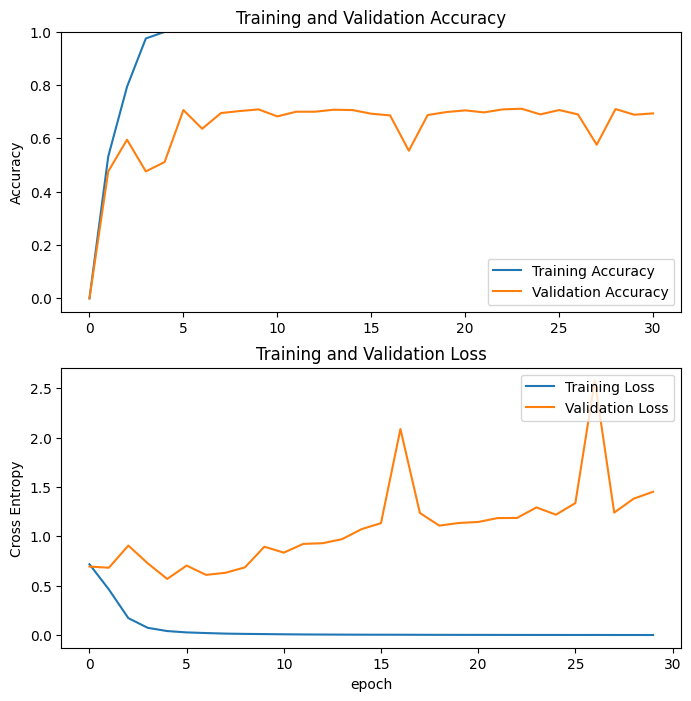

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluate Model

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = combined_model.predict(X_test)
y_pred = np.round(y_pred)

cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

32/32 [==============================] - 0s 5ms/step
Confusion Matrix:
[[276 235]
 [ 64 425]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.54      0.65       511
           1       0.64      0.87      0.74       489

    accuracy                           0.70      1000
   macro avg       0.73      0.70      0.69      1000
weighted avg       0.73      0.70      0.69      1000



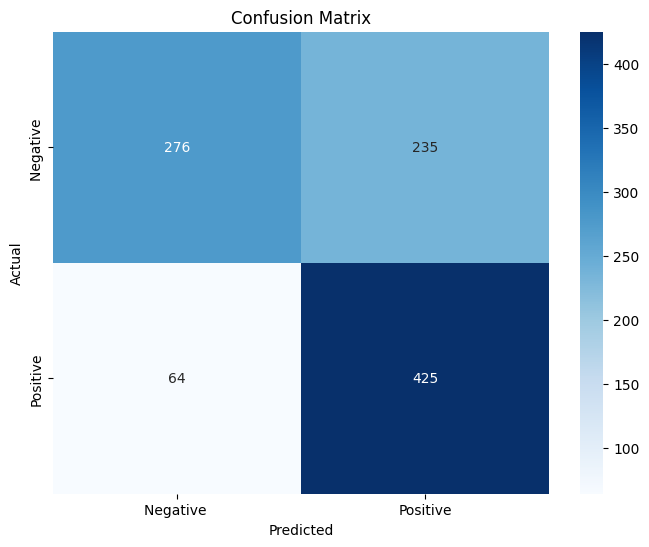

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative ', 'Positive'], yticklabels=['Negative ', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
combined_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 100)         4651300   
                                                                 
 conv1d_4 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, None, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          6176      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, None, 32)          0         
 g1D)                                                      

# Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assume ps_utterance and catlist are processed data
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(ps_utterance, catlist, test_size=0.2, random_state=42)

In [ ]:
# Create a Logistic Regression model
logreg_model = LogisticRegression()

# Train the model on the training set
logreg_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [ ]:
# Make predictions on the testing set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.507


In [ ]:
# Make predictions on the testing set
y_pred = logreg_model.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.554


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Xây dựng mô hình Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

<ipython-input-41-b8412bd52cd8>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


RandomForestClassifier()

In [ ]:
# Dự đoán trên tập kiểm tra
y_pred_rf = rf_model.predict(X_test)

# Đánh giá hiệu suất
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.479


In [ ]:
# Dự đoán trên tập kiểm tra
y_pred_rf = rf_model.predict(X_train)

# Đánh giá hiệu suất
accuracy_rf = accuracy_score(y_train, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 1.0


# Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Xây dựng mô hình Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

In [ ]:
# Dự đoán trên tập kiểm tra
y_pred_nb = nb_model.predict(X_test)

# Đánh giá hiệu suất
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)

Naive Bayes Accuracy: 0.508


In [ ]:
# Dự đoán trên tập kiểm tra
y_pred_nb = nb_model.predict(X_train)

# Đánh giá hiệu suất
accuracy_nb = accuracy_score(y_train, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)

Naive Bayes Accuracy: 0.558
